# **Introduction to Naive Bayes Classifiers**

<div style="text-align: justify;">

***Naive Bayes** is a machine learning classification algorithm based on the Bayes' Theorem that predicts a data point's category based on probability*. It assumes that each feature contributes to the result independently, even if this isn’t always true in reality (this is called the “naive” assumption). Naive Bayes excels in a variety of real-world applications, including spam filtering, document categorisation, and sentiment analysis. This [article](https://www.geeksforgeeks.org/machine-learning/naive-bayes-classifiers/) sums everything up quite nicely. There are **three** types of naive Bayes classifiers, each suited for different types of data:

1. Multinomial Naive Bayes
2. Bernoulli Naive Bayes
3. Gaussian Naive Bayes

**Multinomial Naive Bayes:**
Multinomial Naive Bayes is a version of the Naive Bayes algorithm that is best suited for discrete data and is commonly used in text classification issues like spam detection or sentiment analysis. Instead of just checking whether a word appears or not (which is the working mechanism of Bernoulli Naive Bayes), it looks at how many times each word repeats in a document and uses those counts to calculate probabilities for each class. For more details, refer to this [article](https://www.geeksforgeeks.org/machine-learning/multinomial-naive-bayes/).

**Bernoulli Naive Bayes:**
Bernoulli Naive Bayes is another category of the Naive Bayes algorithm which is primarily used with binary data and uses the Bernoulli distribution to model feature occurrence. It is used to classify binary features like "yes" or "no", "1" or "0", "true" or "false", and so on. It converts each document into a set of 1s and 0s and learns how likely each word is to appear in different classes. It only considers whether a word or feature is present or absent instead of how often it appears (which is the working mechanism of Multinomial Naive Bayes). This [article](https://www.geeksforgeeks.org/machine-learning/bernoulli-naive-bayes/) digs deep into this.

**Gaussian Naive Bayes:**
Gaussian Naive Bayes is another Naive Bayes algorithm that works with continuous attributes and data features that have a Gaussian (normal) distribution over the dataset. This model was designed for datasets with numerical or continuous features instead of word counts. Gaussian Naive Bayes is commonly used because it works well with small datasets and is simple to build and comprehend. This method works best when features are real-valued, such as TF-IDF scores, pixel intensities, or sensor data, and is known for being fast and effective even with limited training examples. This [article](https://www.geeksforgeeks.org/machine-learning/gaussian-naive-bayes/) provides more information.

</div>

# **Data Preparation**

In [39]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset Loading

<div style="text-align: justify;">

This notebook goes through the three Naive Bayes classifiers (Gaussian, Multinomial, and Bernoulli) using the sklearn library. The dataset used is the **SMS Spam Collection** dataset, which is a set of 5572 SMS tagged messages that have been collected for mobile phone spam research. The dataset is available [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip) if want to download and work manually or [here](https://archive.ics.uci.edu/dataset/228/sms+spam+collection) if want to directly fetch from online. Both versions of the code are tied with a `try-except` block. If the local file is not found, it will fetch from online.

</div>

In [40]:
# Try to load the local file first
try:
    sms = pd.read_csv(filepath_or_buffer = "SMSSpamCollection", sep = "\t", header = None, names = ["label", "message"])
    print("File loaded successfully from local storage.")

## If file not found, download and load it from the web
# Some guidance from AI were taken for loading the dataset from web
except FileNotFoundError:
    print("Local file not found. Fetching it online...")

    # Downloading the zip file from UCI repository
    import requests, zipfile, io
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
    r = requests.get(url)

    # Extract and read the data file inside the zip
    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        with z.open("SMSSpamCollection") as f:
            sms = pd.read_csv(filepath_or_buffer = f, sep = "\t", header = None, names = ["label", "message"])

    print("File successfully fetched online and loaded.")

# Display first few rows
sms.head(n = 10)

File loaded successfully from local storage.


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


### Distribution Checking of the Target Variable

We quickly check the proportion of hams and spams to check the overall balance. This will later help us in the train-test split.

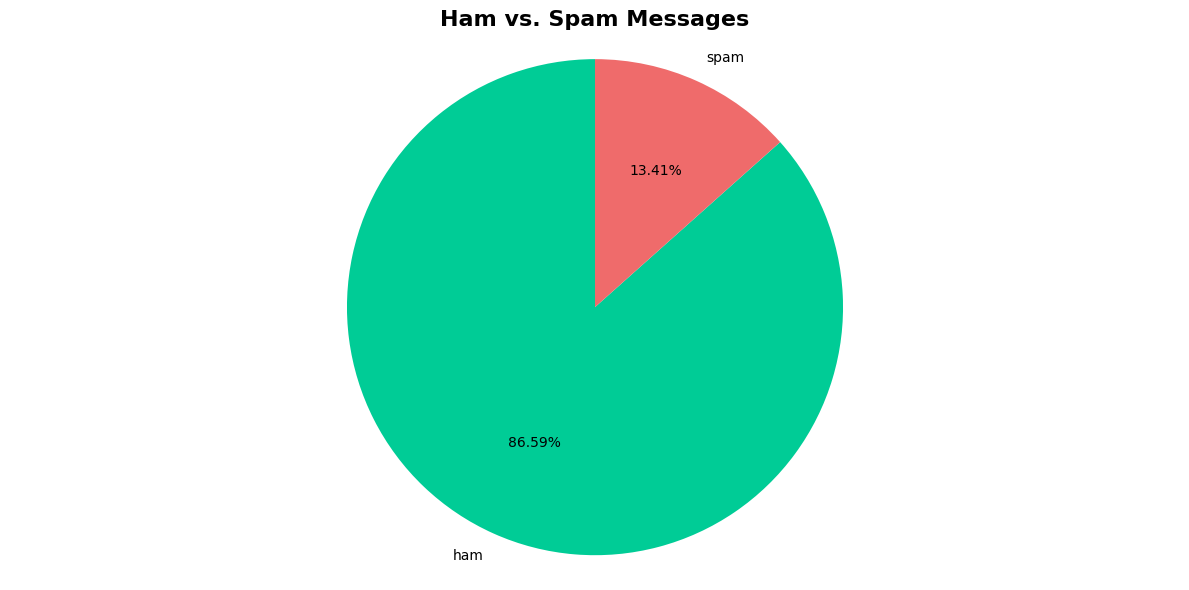

In [41]:
# Calculating the ratio of hams and spams
spam_ham_ratio = round(number = sms["label"].value_counts(normalize = True), ndigits = 4) * 100

## Some help from ChatGPT were taken to build this pie-chart
# Create a simple pie chart
plt.figure(figsize = (12, 6))
plt.pie(
    x = spam_ham_ratio.values,
    labels = spam_ham_ratio.index,
    autopct = "%1.2f%%",
    colors = ["#00CC96", "#EF6B6B"],
    startangle = 90
)

plt.title(label = "Ham vs. Spam Messages", fontsize = 16, fontweight = "bold")
plt.axis("equal")
plt.tight_layout()
plt.show()

So, this dataset has roughly **87%** ham messages and **13%** spam messages. The dataset is imbalanced, which means that the number of instances in each class is not equal. This can lead to biased results if not handled properly. We will preserve this spam:ham ratio while splitting the dataset.

## Preprocessing the data

### Target Variable Encoding

We encode the labels, where `ham` is encoded as 0 and `spam` is encoded as 1.

In [42]:
# Encoding the target variable
sms["label_encoding"] = sms["label"].map({"ham": 0, "spam": 1})

### Train-Test Split

<div style="text-align: justify;">

Now, time for a train-test split. We will use **70%** of the data for training and **30%** for testing. We will also use stratified sampling to ensure that the proportion of ham and spam messages is the same in both the training and testing sets. But, we have also replicated the model without stratified sampling and found that the results do not vary significantly. So, we will proceed with stratified sampling.

</div>

In [43]:
# Conducting the train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    sms["message"],
    sms["label_encoding"],
    test_size = 0.3,
    stratify = sms["label_encoding"],
    random_state = 49
)

### Text Data Encoding

<div style="text-align: justify;">

Now, we encode the data for the respective models. We encode the data using `CountVectorizer` for Multinomial Naive Bayes. This encoder converts a collection of text documents to a matrix of token counts, i.e., it counts how many times each word appears. Bernoulli Naive Bayes also uses the same encoder, but it converts the counts to binary values (1 if the word is present, 0 if not), i.e., `CountVectorizer(binary = True)`. Finally, Gaussian Naive Bayes uses `TfidfVectorizer`, which converts the text documents to a matrix of TF-IDF features. **TF-IDF** stands for *Term Frequency-Inverse Document Frequency*, which reflects how important a word is to a document in a collection or corpus. We convert the encoded data to arrays using the `.toarray()` method because Gaussian Naive Bayes requires the input to be in array format.

We also used `stop_words = "english"` in both vectorizers to remove common English words that may not be useful for classification. Examples of such stop words include "the", "is", "in", "and", etc. Removing these words can help improve the performance of the model by reducing noise in the data.

</div>

In [44]:
# MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
vectoriser_mnb = CountVectorizer(stop_words = "english")
X_train_mnb = vectoriser_mnb.fit_transform(raw_documents = X_train)
X_test_mnb = vectoriser_mnb.transform(raw_documents = X_test)

# BernoulliNB
vectoriser_bnb = CountVectorizer(stop_words = "english", binary = True)
X_train_bnb = vectoriser_bnb.fit_transform(raw_documents = X_train)
X_test_bnb = vectoriser_bnb.transform(raw_documents = X_test)

# GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
vectoriser_gnb = TfidfVectorizer(stop_words = "english")
X_train_gnb = vectoriser_gnb.fit_transform(raw_documents = X_train).toarray()
X_test_gnb = vectoriser_gnb.transform(raw_documents = X_test).toarray()

# **Model Training & Evaluation**

## Model Training

We call the necessary libraries, create the respective model objects, fit the models with the training data, and make predictions with the test data. We will check the results in the next couple of cells.

In [45]:
# MultinomialNB
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X = X_train_mnb, y = y_train)
y_predict_test_mnb = mnb.predict(X = X_test_mnb)

# BernoulliNB
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(X = X_train_bnb, y = y_train)
y_predict_test_bnb = bnb.predict(X = X_test_bnb)

# GaussianNB
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X = X_train_gnb, y = y_train)
y_predict_test_gnb = gnb.predict(X = X_test_gnb)

## Performance & Evaluation

### Accuracy Scores & Classification Reports

Now, we calculate the accuracy scores of all the models along with their classification reports. Then we print them together to get a comprehensive report of all the models' performances

In [46]:
# Importing the necessary libraries
from sklearn.metrics import accuracy_score, classification_report

# Calculating the accuracy scores for test datasets of the the three models
accuracy_test_mnb = accuracy_score(y_true = y_test, y_pred = y_predict_test_mnb)
accuracy_test_bnb = accuracy_score(y_true = y_test, y_pred = y_predict_test_bnb)
accuracy_test_gnb = accuracy_score(y_true = y_test, y_pred = y_predict_test_gnb)

# Generating the Classification reports for test datasets of the the three models
report_mnb = classification_report(y_true = y_test, y_pred = y_predict_test_mnb)
report_bnb = classification_report(y_true = y_test, y_pred = y_predict_test_bnb)
report_gnb = classification_report(y_true = y_test, y_pred = y_predict_test_gnb)

# Printing a comprehensive summary Report of the three models
print(
f"""Model Performance Report
         
Report for Multinomial Naive Bayes
Accuracy Score: {accuracy_test_mnb:.3%}
{report_mnb}

Report for Bernoulli Naive Bayes
Accuracy Score: {accuracy_test_bnb:.3%}
{report_bnb}

Report for Gaussian Naive Bayes
Accuracy Score: {accuracy_test_gnb:.3%}
{report_gnb}"""
)

Model Performance Report
         
Report for Multinomial Naive Bayes
Accuracy Score: 98.684%
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1448
           1       0.97      0.93      0.95       224

    accuracy                           0.99      1672
   macro avg       0.98      0.96      0.97      1672
weighted avg       0.99      0.99      0.99      1672


Report for Bernoulli Naive Bayes
Accuracy Score: 97.189%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1448
           1       0.99      0.79      0.88       224

    accuracy                           0.97      1672
   macro avg       0.98      0.90      0.93      1672
weighted avg       0.97      0.97      0.97      1672


Report for Gaussian Naive Bayes
Accuracy Score: 87.739%
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      1448
           1       0.52     

#### **Key Insights**

<div style="text-align: justify;">

* For detecting spam messages (class 1), **Multinomial Naive Bayes** achieved the best balance with precision = 0.97, recall = 0.93, and F1 = 0.95, correctly identifying most spam messages with very few false alarms.

* **Bernoulli Naive Bayes** had slightly higher precision (0.99) but much lower recall (0.79), missing more spam messages.

* **Gaussian Naive Bayes** performed the worst on spam detection, with low precision (0.52) despite good recall (0.92), meaning it incorrectly labeled many ham messages as spam.

</div>

### Confusion Matrices

Now, we generate the confusion matrices for all three models and plot them side by side for a quick and easier comparison. We also formatted the graph accordingly.

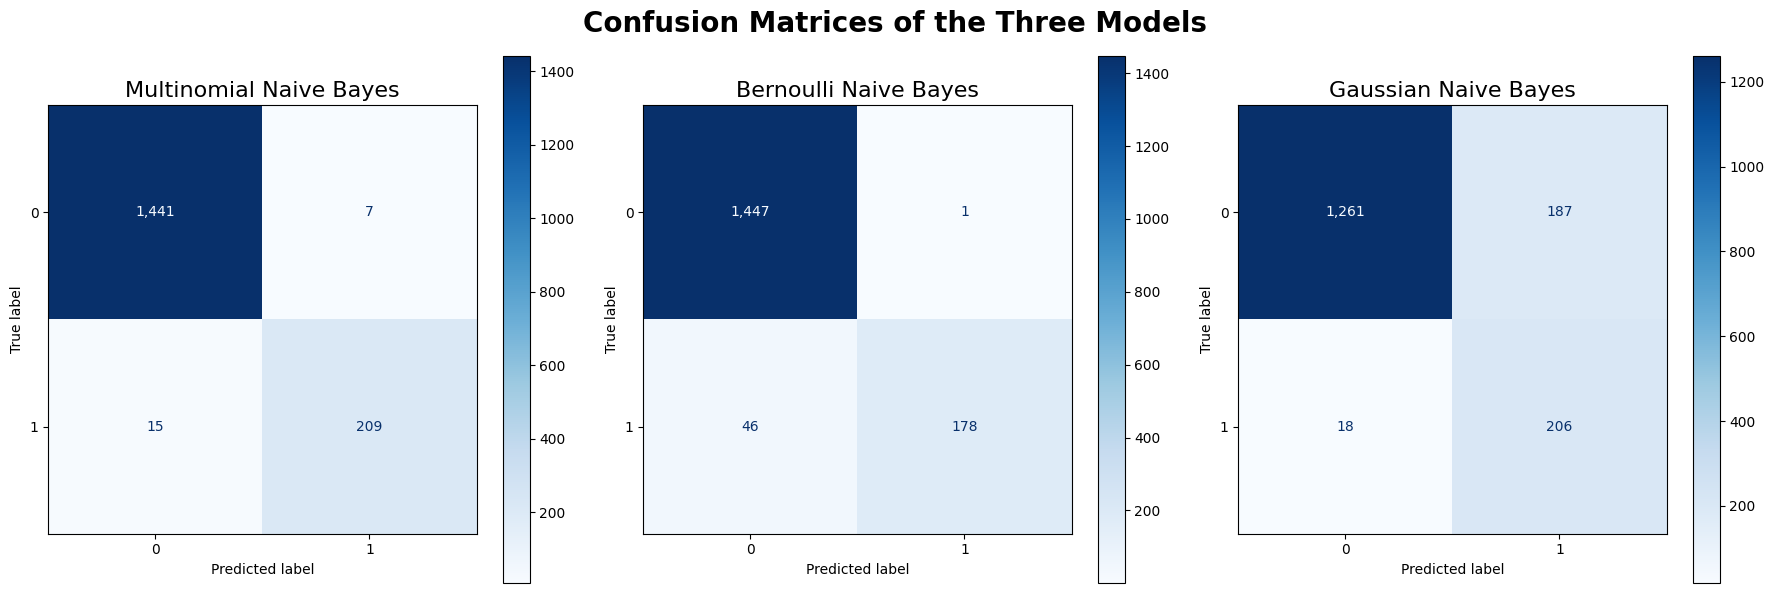

In [47]:
# Importing the necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Setting up the plot size for side-by-side display
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 6))
fig.suptitle(t = "Confusion Matrices of the Three Models", fontsize = 20, fontweight = "bold")

# MultinomialNB
matrix_mnb = confusion_matrix(y_true = y_test, y_pred = y_predict_test_mnb)
ConfusionMatrixDisplay(confusion_matrix = matrix_mnb).plot(ax = axes[0], cmap = "Blues", values_format = ",.0f")
axes[0].set_title(label = "Multinomial Naive Bayes", fontsize = 16)

# BernoulliNB
matrix_bnb = confusion_matrix(y_true = y_test, y_pred = y_predict_test_bnb)
ConfusionMatrixDisplay(confusion_matrix = matrix_bnb).plot(ax = axes[1], cmap = "Blues", values_format = ",.0f")
axes[1].set_title(label = "Bernoulli Naive Bayes", fontsize = 16)

# GaussianNB
matrix_gnb = confusion_matrix(y_true = y_test, y_pred = y_predict_test_gnb)
ConfusionMatrixDisplay(confusion_matrix = matrix_gnb).plot(ax = axes[2], cmap = "Blues", values_format = ",.0f")
axes[2].set_title(label = "Gaussian Naive Bayes", fontsize = 16)

# Displaying the subplots
plt.tight_layout()
plt.show()

#### **Key Insights**

<div style="text-align: justify;">

Now, our goals are to either have the minimum number false positive or false negative predictions. Depending on the context and what we want to achieve, we can choose to prioritize one over the other.

* If our objective is to minimize false positives, i.e., we want to avoid incorrectly identifying a ham message as spam, then the best model would be the one with the lowest false positive rate. In this case, that model here is the **Bernoulli Naive Bayes** model (only 1 out of 1448). We must choose this model if we absolutely cannot afford to lose important emails (like business communications, bank notifications, etc.).

* On the other hand, if our objective is to minimize false negatives, i.e., we want to avoid incorrectly identifying a spam message as ham, then the best model would be the one with the lowest false negative rate. In this case, that model here is the **Multinomial Naive Bayes** model (only 15 out of 224). We will choose this model if security and avoiding malicious content is our priority.

* If we are looking for a balance between the false positive and false negative on the other hand, **Multinomial Bayes Model** is the best among the three. It catches almost the majority of the spam messages (209 messages in true positive) whilst having the least number of false negative messages and second least number of false positive messages.

</div>

### Receiver Operating Characteristic (**ROC**) Curves & Area Under Curve (**AUC**) Scores

Generating the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for all three models to plot the ROC Curves. In this cell, we only calculate these values. In the next couple of cells, we will calculate the ROC-AUC scores and plot them with the ROC curves in the same graph.

In [48]:
# Importing the necessary library
from sklearn.metrics import roc_curve

# MultinomialNB
y_prob_mnb = mnb.predict_proba(X = X_test_mnb)[:, 1]
fpr_mnb, tpr_mnb, thresholds_mnb = roc_curve(y_true = y_test, y_score = y_prob_mnb)

# BernoulliNB
y_prob_bnb = bnb.predict_proba(X = X_test_bnb)[:, 1]
fpr_bnb, tpr_bnb, thresholds_bnb = roc_curve(y_true = y_test, y_score = y_prob_bnb)

# GaussianNB
y_prob_gnb = gnb.predict_proba(X = X_test_gnb)[:, 1]
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_true = y_test, y_score = y_prob_gnb)

Now, we calculate the ROC-AUC for all the three models and take a look at their values.

In [49]:
# Importing the necessary library
from sklearn.metrics import roc_auc_score

# Calculating the ROC-AUC for the three models
roc_score_mnb = roc_auc_score(y_true = y_test, y_score = y_prob_mnb)
roc_score_bnb = roc_auc_score(y_true = y_test, y_score = y_prob_bnb)
roc_score_gnb = roc_auc_score(y_true = y_test, y_score = y_prob_gnb)

# PRinting the results
print(
f"""ROC-AUC Scores of the Three Models
      
Multinomial Naive Bayes: {roc_score_mnb:.3%}
Bernoulli Naive Bayes: {roc_score_bnb:.3%}
Gaussian Naive Bayes: {roc_score_gnb:.3%}"""
)

ROC-AUC Scores of the Three Models
      
Multinomial Naive Bayes: 99.066%
Bernoulli Naive Bayes: 99.128%
Gaussian Naive Bayes: 89.525%


Now, we plot the ROC curves of all the three models along with their ROC-AUC scores in the same graph for a better comparison. We colour-coded the curves and formatted the graph accordingly for easier comparison.

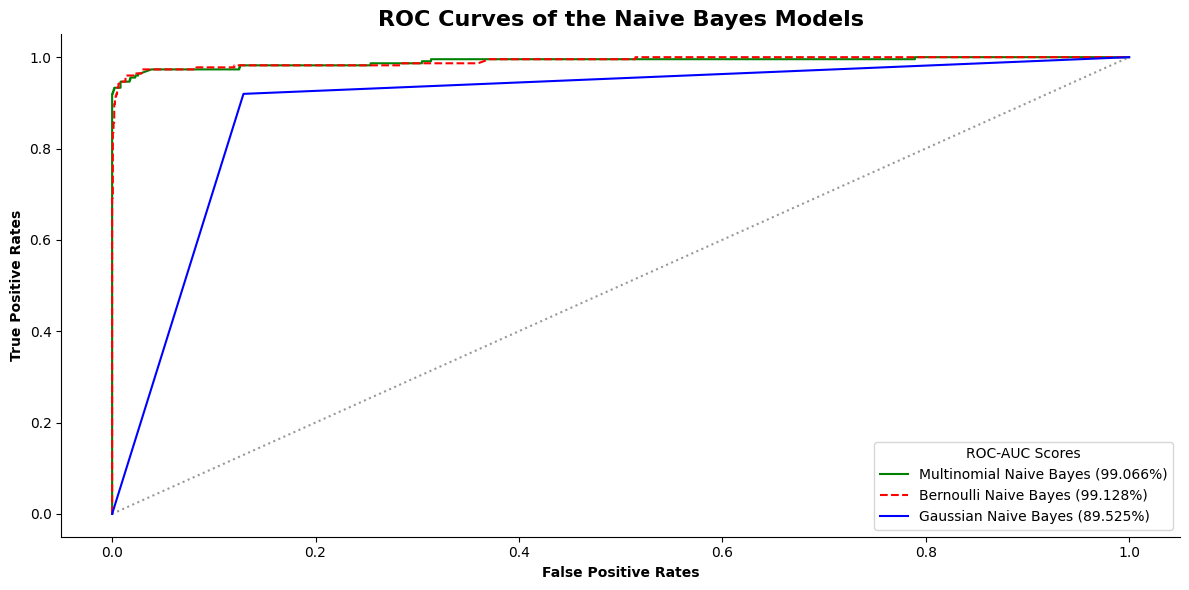

In [50]:
# Fixing the plot size
plt.figure(figsize = (12,6))

# Plotting a 45-degree reference line
plt.plot([0, 1], [0, 1], color = "black", linestyle = "dotted", alpha = 0.4)

# Plotting the ROC curves
plt.plot(fpr_mnb, tpr_mnb, label = f"Multinomial Naive Bayes ({roc_score_mnb:.3%})", color = "green")
plt.plot(fpr_bnb, tpr_bnb, label = f"Bernoulli Naive Bayes ({roc_score_bnb:.3%})", color = "red", linestyle = "--")
plt.plot(fpr_gnb, tpr_gnb, label = f"Gaussian Naive Bayes ({roc_score_gnb:.3%})", color = "blue")

# Formatting the plot
plt.title(label = "ROC Curves of the Naive Bayes Models", fontsize = 16, fontweight = "bold")
plt.xlabel(xlabel = "False Positive Rates", fontweight = "bold")
plt.ylabel(ylabel = "True Positive Rates", fontweight = "bold")
plt.legend(title = "ROC-AUC Scores", loc = 4)
sns.despine()
plt.tight_layout()
plt.tight_layout()

#### **Key Insights**

<div style="text-align: justify;">

* The ROC curves show that **Multinomial Naive Bayes** and **Bernoulli Naive Bayes** both achieved excellent discrimination ability between spam and ham messages, with AUC scores of 99.066% and 99.128% respectively. They can be considered almost equal if we account for the decimal places. Their ROC curves nearly touch the top-left corner, indicating near-perfect classification performance.

* In contrast, **Gaussian Naive Bayes** performed notably worse, with an AUC of 89.53%, showing that it is less effective at distinguishing between the two classes.

</div>

### Overfitting Check

<div style="text-align: justify;">

Before finally selecting on a model, we want to check whether any of the models have any overfitting issues. ***Overfitting** is a common problem in machine learning where a model learns the training data too well, including its noise and specific patterns, making it perform poorly on new, unseen data*. 

Usually one of the taletell signs of overfitting is a large difference between the training and testing accuracies of a model. If a model has a very high training accuracy but a significantly lower testing accuracy, it may be overfitting the training data. We have already determined the accuracy scores of the test data of the models, now we start by calculating the training accuracies of all three models.

</div>

In [ ]:
## Some help from AI were taken for this part of the code
# First, we determine the y_predict values of the train datasets for the models
y_predict_train_mnb = mnb.predict(X = X_train_mnb)
y_predict_train_bnb = bnb.predict(X = X_train_bnb)
y_predict_train_gnb = gnb.predict(X = X_train_gnb)

# Calculating the accuracy scores of the train dataset for the three models
accuracy_train_mnb = accuracy_score(y_true = y_train, y_pred = y_predict_train_mnb)
accuracy_train_bnb = accuracy_score(y_true = y_train, y_pred = y_predict_train_bnb)
accuracy_train_gnb = accuracy_score(y_true = y_train, y_pred = y_predict_train_gnb)

# Printing the accuracy scores of both the train and test datasets and checking the difference
print(
f"""Train & Test Accuracy & their Differences

For Multinomial Naive Bayes
Train Accuracy: {accuracy_train_mnb:.2%}
Test Accuracy: {accuracy_test_mnb:.2%}%
Difference in accuracy: {abs(accuracy_train_mnb - accuracy_test_mnb):.2%}

For Bernoulli Naive Bayes
Train Accuracy: {accuracy_train_bnb:.2%}
Test Accuracy: {accuracy_test_bnb:.2%}
Difference in accuracy: {abs(accuracy_train_bnb - accuracy_test_bnb):.2%}

For Gaussian Naive Bayes
Train Accuracy: {accuracy_train_gnb:.2%}
Test Accuracy: {accuracy_test_gnb:.2%}
Difference in accuracy: {abs(accuracy_train_gnb - accuracy_test_gnb):.2%}"""
)

Train & Test Accuracy and their Differences

For Multinomial Naive Bayes
Train Accuracy: 99.36%
Test Accuracy: 98.68%%
Difference in accuracy: 0.67%

For Bernoulli Naive Bayes
Train Accuracy: 98.51%
Test Accuracy: 97.19%
Difference in accuracy: 1.32%

For Gaussian Naive Bayes
Train Accuracy: 93.77%
Test Accuracy: 87.74%
Difference in accuracy: 6.03%


#### **Key Insights**

<div style="text-align: justify;">

* The train–test accuracy comparison shows that **Multinomial Naive Bayes** generalizes the best, with nearly identical training (99.36%) and testing (98.68%) accuracies and the smallest gap (0.67%), indicating minimal overfitting.

* **Bernoulli Naive Bayes** also performs well, though its slightly larger gap (1.32%) suggests a bit higher variance but still stable performance.

* In contrast, **Gaussian Naive Bayes** displays a significant gap (6.03%), meaning it performs much better on training data than on unseen data, a sign of overfitting.

So, from the above data we can see that, MultinomialNB shows the best generalization and is the most reliable model for spam detection, while GaussianNB struggles due to its mismatch with text data.

</div>

### Cross-Validation Check

<div style="text-align: justify;">

Now, we want to have another check on how our models perform on new and unseen data. Another method of testing this is through cross-validation. ***Cross-validation** is a statistical technique used to evaluate machine learning models by splitting the data into multiple subsets and training/testing the model multiple times to get a more robust estimate of its performance*.

Instead of doing just one train–test split, cross-validation splits the data multiple times in different ways and checks model performance across all splits. This gives us a more reliable estimate of how well the model will perform in the real world.

For this dataset, we perform a **k-Fold Cross Validation**, one of the most common cross-validation methods. In k-Fold Cross Validation, the dataset is divided into `k` equal parts or folds. The model is trained on `k-1` folds and tested on the remaining fold. This process is repeated `k` times, with each fold being used as the test set once. The final performance metric is then averaged over all `k` iterations to provide a more robust estimate of the model's performance. For our dataset, we use a **5**-Fold Cross Validation.

</div>

Cross Validation Results of the Three Models

Multinomial Naive Bayes: 97.59% ± 0.53%
Bernoulli Naive Bayes: 97.08% ± 0.38%
Gaussian Naive Bayes: 87.05% ± 1.00%


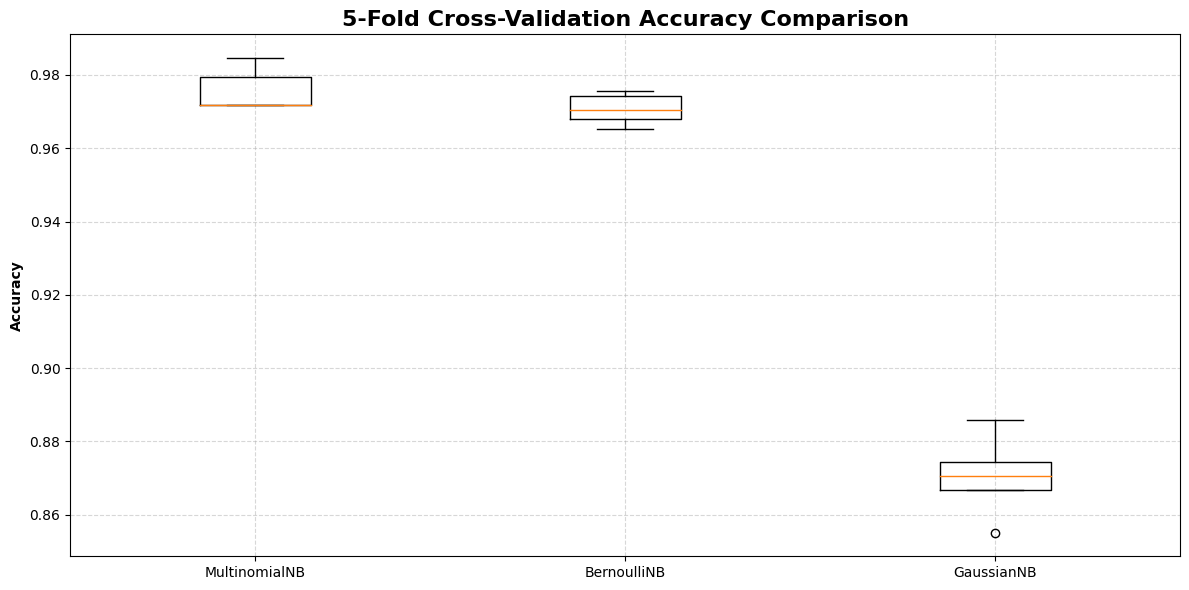

In [ ]:
## Some help from AI were taken for this part of the code
# Importing the necessary library
from sklearn.model_selection import cross_val_score

# Calculating the cross validation scores of the three models
mv_mnb = cross_val_score(estimator = mnb, X = X_train_mnb, y = y_train, cv = 5, scoring = "accuracy")
mv_bnb = cross_val_score(estimator = bnb, X = X_train_bnb, y = y_train, cv = 5, scoring = "accuracy")
mv_gnb = cross_val_score(estimator = gnb, X = X_train_gnb, y = y_train, cv = 5, scoring = "accuracy")

# Printing the results
print(
f"""Cross Validation Results of the Three Models

Multinomial Naive Bayes: {np.mean(mv_mnb):.2%} ± {np.std(mv_mnb):.2%}
Bernoulli Naive Bayes: {np.mean(mv_bnb):.2%} ± {np.std(mv_bnb):.2%}
Gaussian Naive Bayes: {np.mean(mv_gnb):.2%} ± {np.std(mv_gnb):.2%}"""
)

## Visualizing the results for a better overview
# Setting up the plot
plt.figure(figsize = (12, 6))

# Creating a boxplot
plt.boxplot(x = [mv_mnb, mv_bnb, mv_gnb], labels = ["MultinomialNB", "BernoulliNB", "GaussianNB"])
plt.title(label = "5-Fold Cross-Validation Accuracy Comparison", fontsize = 16, fontweight = "bold")
plt.ylabel(ylabel = "Accuracy", fontweight = "bold")
plt.grid(visible = True, linestyle = "--", alpha = 0.5)
plt.tight_layout()
plt.show()

#### **Key Insights**

<div style="text-align: justify;">

Among the three models, **Multinomial Naive Bayes** achieved the highest and most consistent performance (97.59% ± 0.53%), followed closely by **Bernoulli Naive Bayes** (97.08% ± 0.38%), while **Gaussian Naive Bayes** lagged far behind. Both MultinomialNB and BernoulliNB demonstrated excellent generalisation and stability across folds, indicating strong generalization and low variance. They also confirmed that the models are not overfitting and perform consistently across multiple splits of the data. GaussianNB, however, performed worse due to its assumption of continuous, normally distributed features, which does not align with text-based TF-IDF or count data.

To check their performance across the folds, we can visualize the results using a heatmap.

</div>

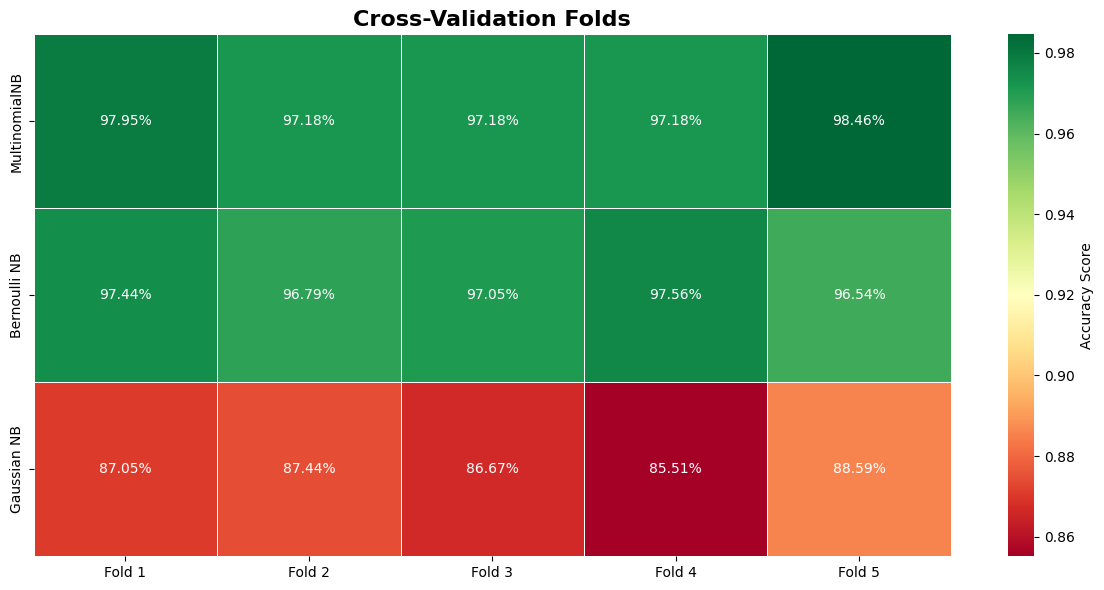

In [53]:
## Some help from AI were taken for this part of the code
# Create a DataFrame for the heatmap
heatmap_df = pd.DataFrame(
    {
        "Fold 1": [mv_mnb[0], mv_bnb[0], mv_gnb[0]],
        "Fold 2": [mv_mnb[1], mv_bnb[1], mv_gnb[1]],
        "Fold 3": [mv_mnb[2], mv_bnb[2], mv_gnb[2]],
        "Fold 4": [mv_mnb[3], mv_bnb[3], mv_gnb[3]],
        "Fold 5": [mv_mnb[4], mv_bnb[4], mv_gnb[4]]
    }, index = ["MultinomialNB", "Bernoulli NB", "Gaussian NB"]
)

# Setting up the plot
plt.figure(figsize = (12, 6))

# Creating the heatmap
sns.heatmap(
    data = heatmap_df, 
    annot = True, 
    fmt = ".2%", 
    cmap = "RdYlGn", 
    cbar_kws = {"label": "Accuracy Score"}, 
    linewidths = 0.5, 
    linecolor = "white"
)
plt.title(label = "Cross-Validation Folds", fontsize = 16, fontweight = "bold")
plt.tight_layout()
plt.show()

### Model Comparison across Three Metrics

<div style="text-align: justify;">

Finally, we want to compare the performance of the three models across **three** specific metrics: Accuracy, F1-Score, and ROC-AUC Score. We will create a bar plot for each metric to visually compare the models.

To do that, we first create a dataframe that contains the metrics for each model called `metric_data`. Then, we use the `melt` function from pandas to transform the dataframe into a long format suitable for seaborn's `barplot` function. Finally, we plot the bar plots for each metric using seaborn's `barplot` function and format the graphs accordingly.

</div>

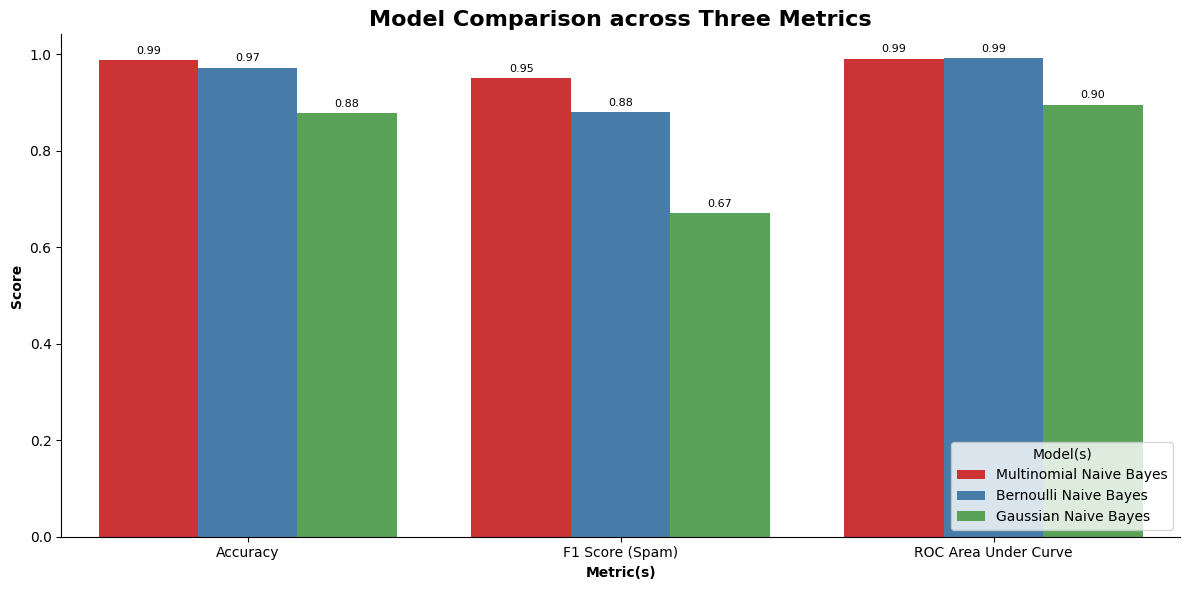

In [60]:
# Create e short dataset for the visualization
metric_data = pd.DataFrame(
    {
        "Model": ["Multinomial Naive Bayes", "Bernoulli Naive Bayes", "Gaussian Naive Bayes"],
        "Accuracy": [accuracy_test_mnb, accuracy_test_bnb, accuracy_test_gnb],
        "F1 Score (Spam)": [0.95, 0.88, 0.67],
        "ROC Area Under Curve": [roc_score_mnb, roc_score_bnb, roc_score_gnb,]
    }
)

# Melt the dataset to long format for seaborn
metric_data_melted = metric_data.melt(
    id_vars = "Model",
    value_vars = ["Accuracy", "F1 Score (Spam)", "ROC Area Under Curve"],
    var_name = "Metric",
    value_name = "Score"
)

# Plot side-by-side bar chart
plt.figure(figsize = (12, 6))
ax = sns.barplot(
    data = metric_data_melted,
    x = "Metric",
    y = "Score",
    hue = "Model",
    palette = "Set1"
)

# Adding labels on top of each bar for easier understanding
for container in ax.containers:
    ax.bar_label(container = container, fmt = '%.2f', label_type = "edge", fontsize = 8, padding = 3)

# Formatting the plot
plt.title(label = "Model Comparison across Three Metrics", fontsize = 16, fontweight = "bold")
plt.xlabel(xlabel = "Metric(s)", fontweight = "bold")
plt.ylabel(ylabel = "Score", fontweight = "bold")
plt.legend(title = "Model(s)", loc = 4)
sns.despine()
plt.tight_layout()
plt.show()

#### **Key Insights**

<div style="text-align: justify;">

As we can see from the barchart above, **Multinomial Naive Bayes** scored the highest in Accuracy and F1 Score (Spam) whereas **Bernoulli Naive Bayes** scored the highest in the ROC-AUC Score with MultinomialNB trailing very closely behind. **Gaussian Naive Bayes** scored the lowest in all three metrics. 

Comparing from this chart, we conclude that **Multinomial Naive Bayes** is the best model among the three.

</div>

# **Conclusion**

<div style="text-align: justify;">

So, from the above comparison(s), graphs, and confusion matrixes, we can see that **Multinomial Naive Bayes** emerged as the most effective spam detector, combining high accuracy (98.68%) with consistent generalization across folds. Its probabilistic handling of word frequency data makes it the optimal choice for text classification tasks of this nature.

It makes the perfect sense since it accounts for how many times one word appears in a text. Gaussian Naive Bayes performed poorly because this dataset was a text-based one and GNB performs the best in numeric features. Although the dataset was encoded using TF-IDF, this model was not the best one for this dataset.

<div>

**Performance of MNB**:

| ***Metric*** | **Accuracy** | **Precision** | **Recall** | **F1-score** | **False Positive Rate** | **False Negative Rate** | **ROC-AUC** |
|------------|--------------|---------------|------------|--------------|-------------------------|-------------------------|-------------|
| ***Value***  | 98.68%       | 97%           | 93%        | 95%          | 0.48%                   | 6.70%                   | 99.07%      |

<u>So, to rank the performance of the **three** models</u>:
1. Multinomial Naive Bayes
2. Bernoulli Naive Bayes
3. Gaussian Naive Bayes